**Instructors**: Prof. Keith Chugg (chugg@usc.edu) & Prof. B. Keith Jenkins (jenkins@sipi.usc.edu)

**Notebook**: Written by TA Chengwei

Modified from:

https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb

https://machinelearningmastery.com/how-to-grid-search-hyperparameters-for-pytorch-models/

# Hyper-parameter Tuning of MLP on MNIST (and Fashion MNIST) in PyTorch

In this notebook, we will first use PyTorch to train an ANN/MLP for the FMNIST dataset. 

Then we will tune the hyper-parameters to improve the performance, and see how the hyper-parameters affect the model.

Finally, we use gridsearch in sklearn to find the best hyper-parameters for a model in pytorch.

Make sure torch is installed (https://pytorch.org/)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Read the Data
First, let's get the data. Torchvision provides many built-in datasets including Fashion MNIST. Fashion MNIST is a dataset of 28x28 images of fashion items.

In [80]:
# All datasets are subclasses of torch.utils.data.Dataset i.e, they have __getitem__ and __len__ methods implemented
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]) # transforms.ToTensor() converts the image to a tensor and transforms.Normalize() normalizes the tensor
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

In [3]:
testset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [4]:
image, label = trainset[0] 
print(image.shape) # torch.Size([1, 28, 28])
print(label) 

torch.Size([1, 28, 28])
9


Fashion MNIST dataset comes as train and test sets, of sizes 60,000 and 10,000 respectively.
If we want to use a validation set, we need to create it manually

In [5]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
# Final sizes are 50000, 10000, 10000
print(f'Train set size: {len(trainset)}, Validation set size: {len(valset)}, Test set size: {len(testset)}')

Train set size: 50000, Validation set size: 10000, Test set size: 10000


In PyTorch, data is loaded using data loaders, which are iterators over the dataset.
Data Loaders need a batch size, which is the size of the data batch extracted in each iteration.
We will create a dataloader for each data split.

# ANN/MLP Model Definition
Create a 2-layer neural network. In Pytorch, `nn.Module` is the base class for all neural network modules in PyTorch.
Your models should also subclass this class

In [24]:
# Parameters for the model
n_pixels = 28 * 28
n_classes = 10

# Define the model
class MLP(nn.Module):
    def __init__(self, n_pixels, n_classes, n_hidden): # Define layers in the constructor
        super().__init__()
        self.fc1 = nn.Linear(n_pixels, n_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x): # Define forward pass in the forward method
        x = x.view(x.shape[0], -1)  #flatten into a 784 length tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x # note: no softmax, as this is included in the loss function in PyTorch

For multi-class classification, we use the cross entropy loss function. In pytorch, the input to `nn.CrossEntropyLoss` should be logits not probabilities. The loss function combines softmax with loss calculation for numerical stability. For the optimizer algorithm, we will use Adam, a very popular optimizer.

# Train and validate (test) the Model
Unlike Keras, in Pytorch we need to explicitly write the training functions. This includes iterating over data batches, forward and backward passes, loss caluclation and updating the weights.
We will write two functions. One for trianing loops (to update the weights of the model) and one for validation loop (to evaluate performance).

In [56]:
# Define function to call for each training epoch (one complete pass over the training set)
def train(model, trainloader, criterion, optimizer, device):
    model.train() # set model to training mode
    running_loss = 0; running_acc = 0
    # with tqdm(total=len(trainloader), desc=f"Train", unit="batch") as pbar:
    for n_batch, (images, labels) in enumerate(trainloader): # Iterate over batches
        images, labels = images.to(device), labels.to(device) # Move batch to device
        optimizer.zero_grad()
        output = model(images) # Forward pass
        loss = criterion(output, labels) # Compute loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights
        running_loss += loss.item()
        running_acc += (output.argmax(1) == labels).float().mean().item()
            # pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
            # pbar.update() # Update progress bar
    return running_loss / len(trainloader), running_acc / len(trainloader) # return loss and accuracy for this epoch

In [57]:
# Define function to call for each validation epoch (one complete pass over the validation set)
def validate(model, valloader, criterion, device):
    model.eval() # set model to evaluation mode (e.g. turn off dropout, batchnorm, etc.)
    running_loss = 0; running_acc = 0
    with torch.no_grad(): # no need to compute gradients for validation
        # with tqdm(total=len(valloader), desc=f"Eval", unit="batch") as pbar:
        for n_batch, (images, labels) in enumerate(valloader): # Iterate over batches
            images, labels = images.to(device), labels.to(device) # Move batch to device
            output = model(images) # Forward pass
            loss = criterion(output, labels) # Compute loss
            running_loss += loss.item() 
            running_acc += (output.argmax(1) == labels).float().mean().item()
                # pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
                # pbar.update() # Update progress bar
    return running_loss / len(valloader), running_acc / len(valloader)  # return loss and accuracy for this epoch

In [66]:
def train_valid_wrapper(batchsize = 128, n_hidden = 48, lr = 1e-2, reg_val = 1e-4, device = "cpu"):
    # lr: the learning rate in TF is part of the optimizer.  Default is 1e-2
    
    # dataloader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
    # model
    model = MLP(28 * 28, 10, n_hidden)
    # loss function and optimier 
    criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg_val)

    # Run training and validation loop
    # Save the best model based on validation accuracy
    n_epochs = 30
    best_acc = -1
    train_loss_history = []; train_acc_history = []
    val_loss_history = []; val_acc_history = []
    for epoch in tqdm(range(n_epochs), unit="epoch"): # Iterate over epochs
        # print(f"Epoch {epoch+1} of {n_epochs}")
        train_loss, train_acc  = train(model, trainloader, criterion, optimizer, device) # Train
        val_loss, val_acc = validate(model, valloader, criterion, device) # Validate
        train_loss_history.append(train_loss); train_acc_history.append(train_acc)
        val_loss_history.append(val_loss); val_acc_history.append(val_acc)
        if val_acc > best_acc: # Save best model
            best_acc = val_acc
            torch.save(model, "best_model.pt")
            # torch.save(model.state_dict(), "best_model.pt") # saving model parameters ("state_dict") saves memory and is faster than saving the entire model
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

let batchsize = 32, n_hidden = 48, lr = 1e-2, reg_val = 1e-4

In [64]:
batchsize = 32
train_loss_history, train_acc_history, val_loss_history, val_acc_history = \
    train_valid_wrapper(batchsize = batchsize, n_hidden = 48, lr = 1e-2, reg_val = 1e-4, device = "cpu")

epoch: 100%|██████████| 30/30 [04:29<00:00,  8.99s/epoch]


In [65]:
# Load the best model and evaluate on test set
model = torch.load("best_model.pt")
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)
test_loss, test_acc = validate(model, testloader, criterion=nn.CrossEntropyLoss(), device='cpu')
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.8744


### Batch size
let batch size be larger, say batchsize = 512. Keep other hyperparameters the same

In [68]:
batchsize = 512
train_loss_history2, train_acc_history2, val_loss_history2, val_acc_history2 = \
    train_valid_wrapper(batchsize = batchsize, n_hidden = 48, lr = 1e-2, reg_val = 1e-4, device = "cpu")

100%|██████████| 30/30 [03:10<00:00,  6.34s/epoch]


In [69]:
# Load the best model and evaluate on test set
model = torch.load("best_model.pt")
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)
test_loss, test_acc = validate(model, testloader, criterion=nn.CrossEntropyLoss(), device='cpu')
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.8230


**Effects of batch size**

In this experiment, large batch size leads to 

lower performance (accuracy)

faster speed

### Learning rate
let's increase the learning rate, lr = 1e-1

In [77]:
batchsize = 32
n_hidden = 48
lr = 1e-1
reg_val = 1e-4

train_loss_history3, train_acc_history3, val_loss_history3, val_acc_history3 = \
    train_valid_wrapper(batchsize = batchsize, n_hidden = n_hidden, lr = lr, reg_val = reg_val, device = "cpu")

100%|██████████| 30/30 [04:34<00:00,  9.14s/epoch]


In [78]:
# Load the best model and evaluate on test set
model = torch.load("best_model.pt")
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)
test_loss, test_acc = validate(model, testloader, criterion=nn.CrossEntropyLoss(), device='cpu')
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.8732


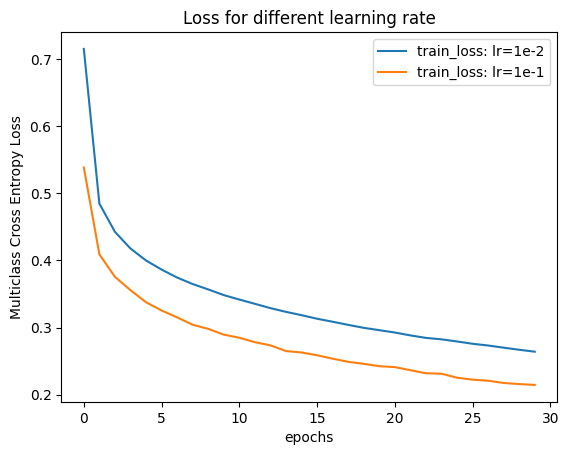

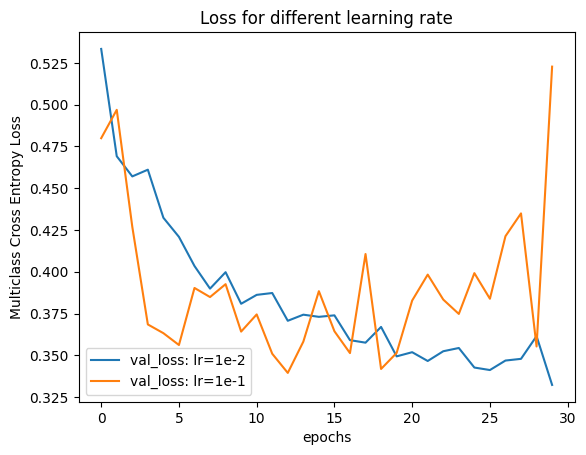

In [79]:
n_epochs = 30
epochs = torch.arange(n_epochs)

# plot training loss
plt.figure()
plt.plot(epochs, train_loss_history, label='train_loss: lr=1e-2')
plt.plot(epochs, train_loss_history3, label='train_loss: lr=1e-1')
plt.xlabel('epochs')
plt.ylabel('Multiclass Cross Entropy Loss')
plt.title(f'Loss for different learning rate')
plt.legend()

# plot validation loss
plt.figure()
plt.plot(epochs, val_loss_history, label='val_loss: lr=1e-2')
plt.plot(epochs, val_loss_history3, label='val_loss: lr=1e-1')
plt.xlabel('epochs')
plt.ylabel('Multiclass Cross Entropy Loss')
plt.title(f'Loss for different learning rate')
plt.legend()

With larger learning rate, the loss function approachs faster to the (local) optimal point.

There is oscillation on validation set. That is learning rate is too large, and optimizer fluctuate around the optimal.

### Search the best parameters for your pytorch model

There are several packages that help you to search the best hyper-parameters.

**RAY TUNE** : https://docs.ray.io/en/latest/tune/index.html

**SKORCH** :A scikit-learn compatible neural network library that wraps PyTorch. https://github.com/skorch-dev/skorch

The following show a example of SKORCH

In [86]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

In [111]:
# Define the model
class MLP(nn.Module):
    def __init__(self, n_hidden): # Define layers in the constructor
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, n_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, 10)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x): # Define forward pass in the forward method
        x = x.view(x.shape[0], -1)  #flatten into a 784 length tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x # note: no softmax, as this is included in the loss function in PyTorch

In [113]:
# create model with skorch
model = NeuralNetClassifier(
    MLP,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    max_epochs=30,
    batch_size=32,
    lr=1e-2,
    iterator_train__shuffle=True
)
 
# define the grid search parameters
# param_grid = {
#     'batch_size': [32, 128, 256],
#     'max_epochs': [10, 50, 100],
#     'optimizer': [optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adam],
#     'optimizer__lr': [0.001, 0.01, 0.1, 0.2, 0.3],
#     'module__n_hidden': [1, 20, 50]
# }
param_grid = {
    'module__n_hidden': [1, 20, 50, 100]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# get X and y from dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False) # make shuffle False
X = np.array([X.cpu().detach().numpy() for X, y in trainloader])
X = np.squeeze(np.concatenate(X, axis=0))
y = np.array([y.cpu().detach().numpy() for X, y in trainloader])
y = np.squeeze(np.concatenate(y, axis=0))
grid_result = grid.fit(X,y) # pytorch dataset may also work https://skorch.readthedocs.io/en/latest/user/neuralnet.html#most-important-arguments-and-methods

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3887       0.1000        2.3220  1.0798
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0406       0.2172        1.9402  1.0916
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0750       0.2401        1.9602  1.1959
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8209       0.7934        0.5802  1.1355
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8379       0.7907        0.5945  1.1980
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8816       0.7

In [114]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.877233 using {'module__n_hidden': 100}
0.370033 (0.010734) with: {'module__n_hidden': 1}
0.864933 (0.005403) with: {'module__n_hidden': 20}
0.873717 (0.002337) with: {'module__n_hidden': 50}
0.877233 (0.003387) with: {'module__n_hidden': 100}
